# Imports

In [1]:
import datetime 
from math import sqrt
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import yfinance as yf
import pyfolio as pf

c:\users\vin_s\appdata\local\programs\python\python39\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


# Signal Construction Helpers

In [2]:
def fill_date(data):
  col_name = data.columns
  data.columns = ["tmp"]
  filled_data = pd.merge(combined_data, data, how="outer", on="Dates").ffill()[["tmp"]]
  filled_data.columns =  [col_name]
  return filled_data

def calc_rolling_vol(series, window, method="simple"):
  return rolling_vol(series, window)

def zscore(series, window):
    m = rolling_mean(series, window)
    s = rolling_vol(series, window)
    z = (series-m)/s
    return z

def rolling_mean(series, window):
  return series.rolling(window=window).mean()

def rolling_vol(series, window):
  return series.rolling(window=window).std(ddof=0)

In [3]:
def calc_scaler(signal = None, asset_returns = None, asset_groups = None, settings = None,
                scaling_target = None, scaling_width = None, scaling_method = None, scaling_cap = None):
    
  if scaling_target <= 0:
    raise Exception("`scaling_target` must be more than 0")
  if scaling_width <= 1:
    raise Exception("`scaling_width` must be more than 1")
  if scaling_method not in ["simple", "exponential"]:
    raise Exception("`scaling_method` can only be simple or exponential")

  if type(signal) == type(None):
    signal_returns = asset_returns
  else:
    signal_returns = signal.shift(settings.implementation_lag + 1) * asset_returns

  signal_return_grouped = pd.DataFrame()  
  if asset_groups:
    print("    Grouping by " + str(list(asset_groups.keys())).replace("'",""))
    for key, value in asset_groups.items():
      signal_return_grouped[key] = signal_returns[value].sum(axis=1)
    vol_scalar = scaling_target/calc_rolling_vol(signal_return_grouped, 
                                               window = scaling_width,
                                               method = scaling_method)/sqrt(260)
  else:
    vol_scalar = scaling_target/calc_rolling_vol(signal_returns, 
                                               window = scaling_width,
                                               method = scaling_method)/sqrt(260)

  if asset_groups:
    vol_scalar_grouped = vol_scalar
    vol_scalar = pd.DataFrame()
    for sector in asset_groups.keys():
      for asset in asset_groups[sector]:
        vol_scalar[asset] = vol_scalar_grouped[sector]
  
  return vol_scalar

# Backtest Engine

## Initialise Returns Data

In [4]:
symbols_list = ["FDX", "BA", "XOM", "CVX", "GE", "UNH", "JNJ", "BRK-A", "BRK-B", "JPM", "BLK", "AMZN", "MCD", "KO", "PG", "AAPL", "MSFT", "FB", "GOOGL", "AMZN", "V", "NVDA", "TSLA"]#["^GSPC", "TSLA", "GOOGL", "WMT", "DIS", "XOM"]
start = datetime.datetime(2011, 1, 1)
end = datetime.datetime(2020, 12, 31)

data = yf.download(symbols_list, start=start, end=end)

[*********************100%***********************]  22 of 22 completed


In [5]:
rtns = data['Adj Close'].pct_change()

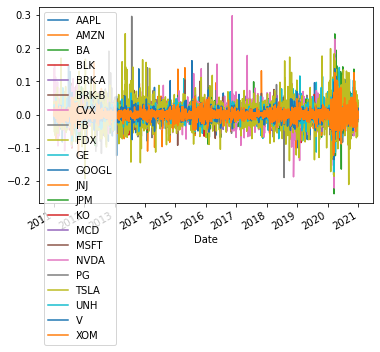

In [6]:
rtns.plot()

In [7]:
rtns

,AAPL,AMZN,BA,BLK,BRK-A,BRK-B,CVX,FB,FDX,GE,...,JPM,KO,MCD,MSFT,NVDA,PG,TSLA,UNH,V,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2010-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-03,0.021733,0.023444,0.017469,-0.002047,0.000399,0.003745,0.007561,NaN,0.001935,-0.000547,...,0.027346,-0.008362,-0.002084,0.002508,0.027273,0.006840,-0.000376,0.028247,0.001990,0.019557
2011-01-04,0.005219,0.004288,0.008132,-0.000789,-0.002473,-0.002985,-0.003698,NaN,-0.000751,0.018053,...,0.014472,-0.020699,-0.029896,0.003932,-0.003161,0.002779,0.001878,0.009157,0.001134,0.004695
2011-01-05,0.008180,0.013026,0.008067,0.010314,0.009151,0.009230,-0.001746,NaN,0.008054,0.001612,...,0.012229,-0.005950,0.004710,-0.003204,0.076728,-0.002309,0.005999,0.003203,0.021104,-0.002670
2011-01-06,-0.000808,-0.008324,0.019561,-0.010781,-0.005771,-0.006674,-0.008202,NaN,-0.008203,-0.004292,...,-0.004922,-0.007245,-0.006027,0.029286,0.138398,-0.001698,0.039135,0.020750,0.014981,0.006426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,-0.006976,-0.006627,0.004159,0.014592,0.002743,0.010636,0.015766,0.003819,-0.009404,0.023563,...,0.027944,0.006065,0.000472,-0.013039,-0.020259,-0.001538,0.008808,0.007701,-0.002623,0.012852
2020-12-24,0.007712,-0.003949,-0.011562,0.005031,0.010579,0.010212,-0.004201,-0.002648,-0.006982,-0.019337,...,-0.004398,0.006782,-0.002972,0.007827,-0.001191,0.010122,0.024444,0.009479,0.016561,-0.004070
2020-12-28,0.035766,0.035071,-0.004881,0.004242,0.006874,0.008299,-0.005039,0.035901,-0.021873,-0.000939,...,0.006585,0.013473,0.012441,0.009921,-0.007215,0.006971,0.002901,0.015141,0.018831,0.003365


## Create Settings object

In [8]:
class Settings:
  def __init__(self, start_date = None, end_date = None, notional = 100, implementation_lag = 1,
               asset_scaling_method = None, asset_scaling_target = None, asset_scaling_width = None, asset_scaling_cap = None, 
               sector_scaling_method = None, sector_scaling_target = None, sector_scaling_width = None, sector_scaling_cap = None,
               portfolio_scaling_method = None, portfolio_scaling_target = None, portfolio_scaling_width = None, portfolio_scaling_cap = None):
    
    self.start_date = start_date
    self.end_date = end_date
    self.notional = notional
    self.implementation_lag = implementation_lag
    
    if self.implementation_lag < 0:
      raise Exception('`implementation_lag must be more than 0 (cannot trade in the past)')
    
    self.asset_scaling_method = asset_scaling_method
    self.asset_scaling_target = asset_scaling_target
    self.asset_scaling_width = asset_scaling_width
    self.asset_scaling_cap = asset_scaling_cap
    
    self.sector_scaling_method = sector_scaling_method
    self.sector_scaling_target = sector_scaling_target
    self.sector_scaling_width = sector_scaling_width
    self.sector_scaling_cap = sector_scaling_cap
    
    self.portfolio_scaling_method = portfolio_scaling_method
    self.portfolio_scaling_target = portfolio_scaling_target
    self.portfolio_scaling_width = portfolio_scaling_width
    self.portfolio_scaling_cap = portfolio_scaling_cap

In [9]:
s = Settings(start_date = "2011-01-01", end_date = "2020-12-31", notional = 100, implementation_lag = 1,
             asset_scaling_method="simple", asset_scaling_target=0.1, asset_scaling_width=130,
             sector_scaling_method="simple", sector_scaling_target=0.1, sector_scaling_width=130,
             portfolio_scaling_method="simple", portfolio_scaling_target=0.1, portfolio_scaling_width=260)

## Create Signal object

## Run Backtest

In [10]:
class Backtest:
  def __init__(self, signal = None, asset_returns = None, tcost = None, asset_groups = None, settings: Settings = None):
    self.signal = signal
    self.asset_returns = asset_returns
    self.tcost = tcost
    self.asset_groups = asset_groups
    self.settings = settings
    
    
    settings_dict = self.settings.__dict__
    for key, value in settings_dict.items():
      setattr(self, key, value)
    
    if (type(self.signal) != pd.DataFrame):
      raise Exception("Attribute `signal` must be a time series DataFrame")
    if (type(self.asset_returns) != pd.DataFrame):
      raise Exception("Attribute `asset_returns` must be a time series DataFrame")
      
    if (type(self.signal.index) != pd.core.indexes.datetimes.DatetimeIndex):
      raise Exception("Attribute `signal` must be a time series DataFrame")
    if (type(self.asset_returns.index) != pd.core.indexes.datetimes.DatetimeIndex):
      raise Exception("Attribute `asset_returns` must be a time series DataFrame")  
    
    if (type(self.signal) == pd.DataFrame):
      if (sorted(self.signal.columns) != sorted(self.asset_returns.columns)):
        raise Exception("Mismatch of assets between `signal` and `asset_returns`")
      if (not set(self.asset_returns.columns).issubset(self.tcost.columns)):
        raise Exception("Missing `tcost` data for some assets")

    if getattr(self, "asset_groups", None) != None:
      if not set(self.signal).issubset([a for b in self.asset_groups.values() for a in b]):
        raise Exception("Some assets in `signal` do not belong in any `asset_groups`")
        
  def run(self):
    if len(self.signal.columns) > 1 and self.asset_scaling_target:
      print("Asset scaling ...")
      self.asset_scaler = calc_scaler(asset_returns = self.asset_returns,
                                           scaling_target = self.asset_scaling_target,
                                           scaling_width = self.asset_scaling_width,
                                           scaling_method = self.asset_scaling_method,
                                           scaling_cap = self.asset_scaling_cap,
                                           settings = self.settings)
    else:
      self.asset_scaler = 1
    
    if self.sector_scaling_target and self.asset_groups:
      print("Sector scaling ...")
      self.sector_scaler = calc_scaler(signal = self.signal * self.asset_scaler,
                                            asset_returns = self.asset_returns,
                                            asset_groups = self.asset_groups,
                                            scaling_target = self.sector_scaling_target,
                                            scaling_width = self.sector_scaling_width,
                                            scaling_method = self.sector_scaling_method,
                                            scaling_cap = self.sector_scaling_cap,
                                            settings = self.settings)
    else:
      self.sector_scaler = 1

    if self.portfolio_scaling_target:
      print("Portfolio scaling ...")
      self.portfolio_scaler = calc_scaler(signal = self.signal * self.asset_scaler * self.sector_scaler,
                                          asset_returns = self.asset_returns,
                                          asset_groups = {"ALL" : list(self.signal.columns)},
                                          scaling_target = self.portfolio_scaling_target,
                                          scaling_width = self.portfolio_scaling_width,
                                          scaling_method = self.portfolio_scaling_method,
                                          scaling_cap = self.portfolio_scaling_cap,
                                          settings = self.settings)
    else:
      self.portfolio_scaler = 1
    self.wts = self.signal * self.asset_scaler * self.sector_scaler * self.portfolio_scaler
    
    self.asset_rtn = self.asset_returns * self.wts.shift(self.implementation_lag + 1)
    self.asset_rtn[np.isfinite(self.asset_rtn) == False] = 0
    self.model_rtn = self.asset_rtn.sum(axis = 1)
    self.pos_chg = self.wts.diff(self.implementation_lag + 1)
    self.wts_tcost = self.pos_chg * self.tcost
      
    self.asset_rtn_tc = self.asset_rtn - self.wts_tcost
    self.model_rtn_tc = self.asset_rtn_tc.sum(axis = 1)
    

In [32]:
signal1 = rolling_mean((rolling_mean(rtns, 65) - rolling_mean(rtns, 20)), 5)

In [33]:
signal2 = rolling_mean(rolling_mean(rtns, 10) * -1, 5)

In [34]:
signal3 = rolling_mean(zscore(rtns, 130), 5)

In [14]:
sectors = {"Finance": ["BRK-A", "BRK-B", "JPM", "BLK"],
           "Tech": ["AAPL", "MSFT", "FB", "GOOGL", "AMZN", "NVDA"],
           "Energy": ["XOM", "CVX", "GE"],
           "Health": ["UNH", "JNJ"],
           "Goods": ["MCD", "KO", "PG", "FDX"],
           "Misc": ["V", "BA", "TSLA"]}

In [35]:
b1 = Backtest(signal = signal1, asset_returns = rtns, tcost = abs(rtns*0), settings = s, asset_groups = sectors)
b1.run()

Asset scaling ...
Sector scaling ...
    Grouping by [Finance, Tech, Energy, Health, Goods, Misc]
Portfolio scaling ...
    Grouping by [ALL]


In [36]:
b2 = Backtest(signal = signal2, asset_returns = rtns, tcost = abs(rtns*0), settings = s, asset_groups = sectors)
b2.run()

Asset scaling ...
Sector scaling ...
    Grouping by [Finance, Tech, Energy, Health, Goods, Misc]
Portfolio scaling ...
    Grouping by [ALL]


In [37]:
b3 = Backtest(signal = signal3, asset_returns = rtns, tcost = abs(rtns*0), settings = s, asset_groups = sectors)
b3.run()

Asset scaling ...
Sector scaling ...
    Grouping by [Finance, Tech, Energy, Health, Goods, Misc]
Portfolio scaling ...
    Grouping by [ALL]


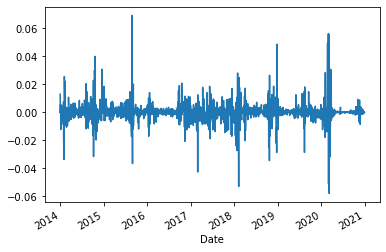

In [17]:
b.model_rtn[b.model_rtn.index > "2014-01-01"].plot()

In [21]:
ann_ret = np.mean(b.model_rtn[b.model_rtn.index > "2014-01-01"]) * 260
ann_vol = np.std(b.model_rtn[b.model_rtn.index > "2014-01-01"]) * np.sqrt(260)
ann_sr  = ann_ret/ann_vol

print("Returns: " + str(ann_ret))
print("Vol:     " + str(ann_vol))
print("SR:      " + str(ann_sr))

Returns: 0.01779692246445551
Vol:     0.11992801261779211
SR:      0.14839670962591453


## Output and log Backtest

## Combine BT

In [60]:
class CombinedBacktest:
  def __init__(self, bt_list, bt_weights):
    self.bt_list = bt_list
    self.bt_weights = bt_weights
    
    self.bt_signals = [x.wts for x  in bt_list]
    self.bt_final_signal = pd.concat(self.bt_signals).groupby(level=0).mean()
    
    self.rtns = bt_list[0].asset_returns    

  def run(self):
    self.bt_final = Backtest(signal = self.bt_final_signal, asset_returns = self.rtns, tcost = abs(self.rtns*0), settings = s, asset_groups = sectors)
    self.bt_final.run()
    
    self.model_rtn = self.bt_final.model_rtn

In [61]:
cb = CombinedBacktest([b1, b2], [0.5, 0.5])
cb.run()

Asset scaling ...
Sector scaling ...
    Grouping by [Finance, Tech, Energy, Health, Goods, Misc]
Portfolio scaling ...
    Grouping by [ALL]


# Post Backtest Analytics

Start date,2014-01-02
End date,2020-12-30
Total months,83
,Backtest
Annual return,3.5%
Cumulative returns,27.3%
Annual volatility,11.6%
Sharpe ratio,0.36
Calmar ratio,0.14
Stability,0.59
Max drawdown,-24.3%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,24.25,2016-11-08,2018-01-26,2020-11-09,1045
1,11.53,2015-08-18,2015-08-25,2016-09-21,287
2,8.75,2014-01-15,2014-02-03,2014-08-13,151
3,8.00,2014-08-19,2014-10-15,2014-10-29,52
4,5.33,2016-09-22,2016-09-26,2016-10-18,19


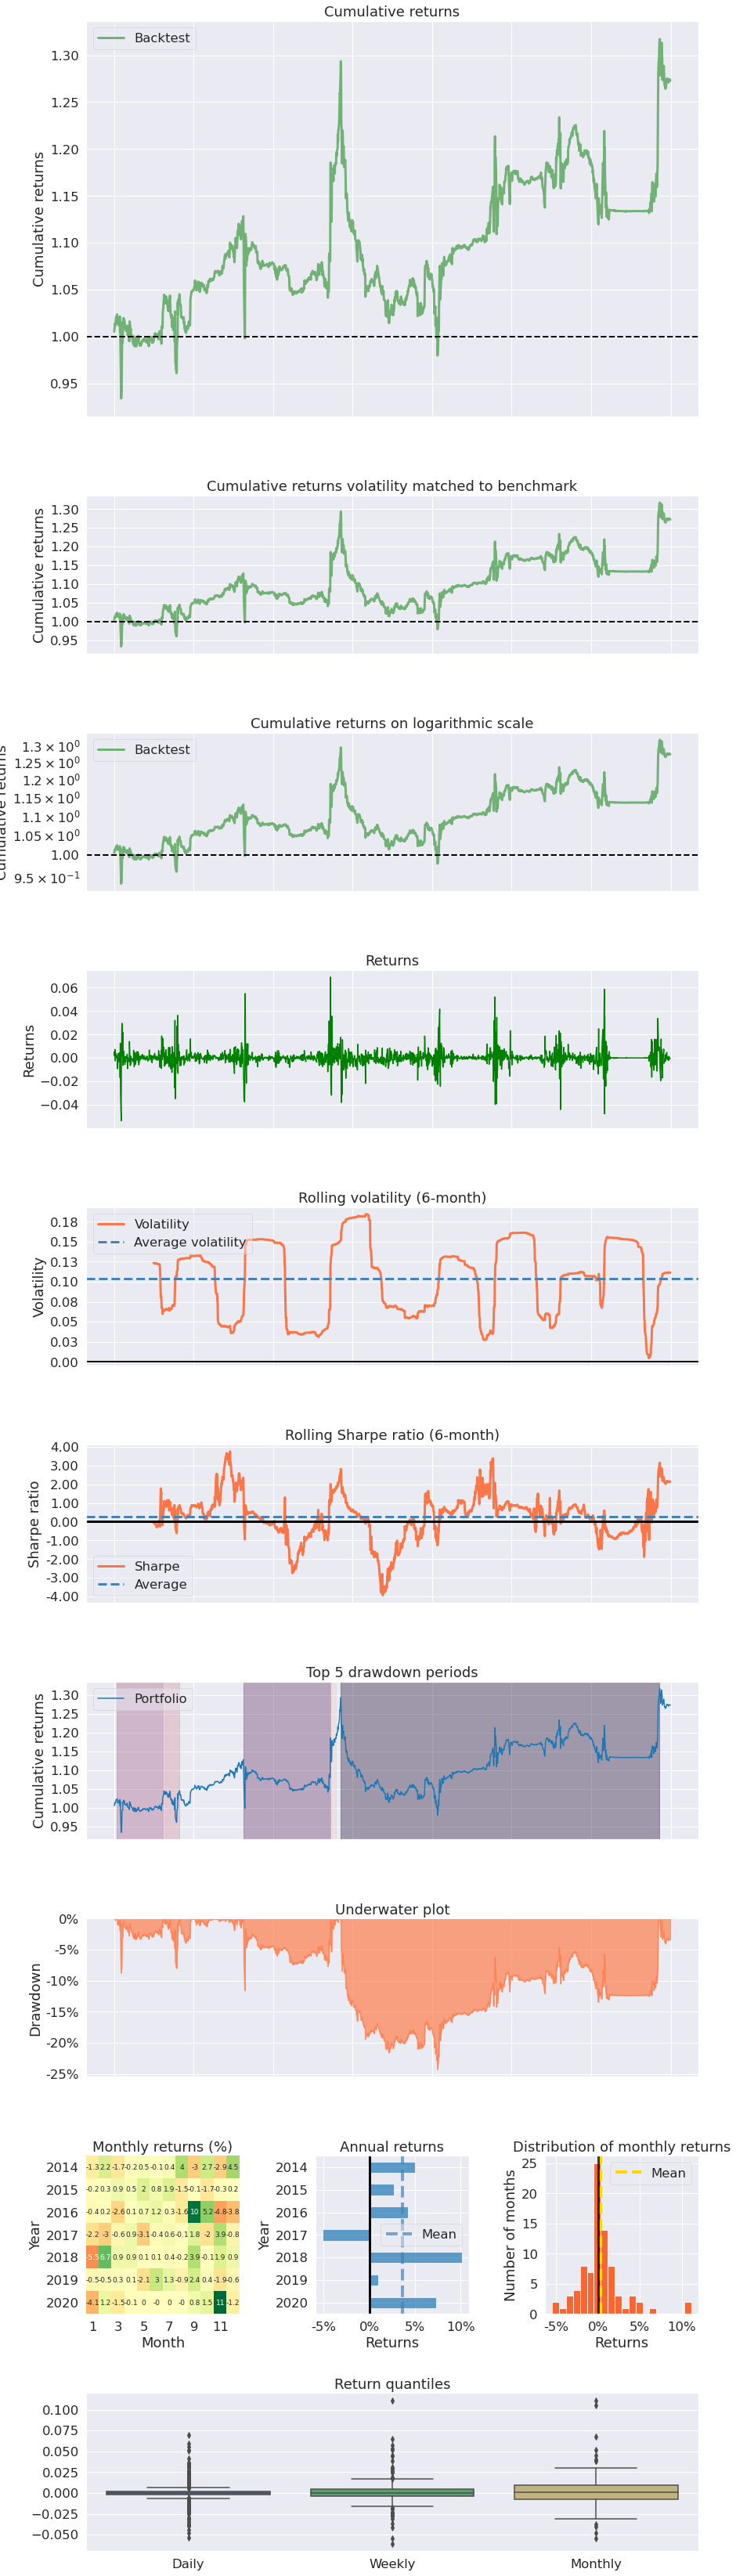

In [62]:
pf.create_returns_tear_sheet(cb.model_rtn[cb.model_rtn.index > "2014-01-01"])

# TODO

In [2]:
# remove leading NAs
# exponential rolling function
# combine bt --> use inheritance
# TC optimizer

# Hit Rate. Win Loss
# MDD 
# By long-short
# Lead Lag